# Music and Movie analysis via Spotify and Netflix

It’s the end of the year when Spotify release 2019 Wrapped. I was amazed how my playlists varied in genres and artists across the globe. I could listen to musical songs non-stop 2 years ago, but my music taste changed to pop and ballad this year. Inspired by Spotify Wrapped, I decided to do a fun analysis not only on mine but also on my boyfriend’s taste in music to figure out what the data will take us. 

In addition to music, I’m curious how similar our movie tastes are by analysing our Netflix viewing history. Understanding these nuances, I can save time on deciding which movies to watch or songs to listen to, and better recommend our common interests when we spend time together. It’s also a special way to show love and care to your loved one ;)

## Outline

1. Data Collection
2. Data Analysis
3. Machine Learning Approach
4. Conclusion


## Data Collection

**1. Spotify:**
In order to read Spotify API, I need to apply for permissions & credentials through their Developer site. I then used a wrapper function in R called spotifyR by Charlie Thompson to extract all albums and songs from my and my boyfriends’ top 10 most listened artists. 
The initial data contains 22 columns with 595 songs from my list and 714 songs from Sang’s list. However, it’s crucial to acknowledge that I didn’t use all 22 variables but only that highly related to the audio features - according to Spotify:

    - Mood: Danceability, Valence, Energy, Tempo
    - Properties: Loudness, Speechiness, Instrumentalness
    - Context: Liveness, Acousticness

 - **Acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

 - **Danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

 - **Energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

 - **Instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

 - **Liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides a strong likelihood that the track is live.

 - **Loudness**: the overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

 - **Speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audiobook, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

 - **Valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

 - **Tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.


**2. Netflix:**
I downloaded our viewing history within 2019 here and merge with the Imdb data sets to extract the movie properties and features.
A drawback from Netflix data set is that it doesn’t log the repeated activities. So if I watched “Stranger Thing” in December 2019, the same episode I watched backed in June will be replaced by that in December. 
I originally downloaded 3 data sets from Imdb with each contains unique properties for movies. I integrated all of these  siloed data sets into one for the purpose of our analysis and only keep the features that matter most:


- **types** - Enumerated set of attributes for this alternative title. One or more of the following: alternative, dvd, festival, tv, video, working, original, imdbDisplay. New values may be added in the future without warning

- **runtimeMinutes** – primary runtime of the title, in minutes

- **Genres** – includes up to three genres associated with the title (Documentary, Drama, Comedy, TV-series, Reality-TV, Crime, Action, Adventure, Thriller, etc.)

- **averageRating** – weighted average of all the individual user ratings

- **numVotes** - number of votes the title has received



In [1]:
#Import necessary Libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn import svm
%matplotlib inline

# Data Analysis

## Music Analysis

## Importing Data

In [2]:
#read in the data that we extract from SpotifyR wrapper function
giang_playlist = pd.read_csv('Spotify/giang_song_list.csv')
sang_playlist = pd.read_csv('Spotify/sang_song_list.csv')

In [3]:
giang_playlist.head()

,owner,artist_name,album_release_date,album_release_year,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,duration_ms,explicit,is_local,track_name,type,album_name,key_name
0,giang,Taylor Swift,2019-08-23,2019,0.664,0.316,5,-10.345,1,0.5190,...,0.0812,0.541,92.875,170640,False,False,I Forgot That You Existed,track,Lover,F
1,giang,Taylor Swift,2019-08-23,2019,0.552,0.702,9,-5.707,1,0.1570,...,0.1050,0.564,169.994,178426,False,False,Cruel Summer,track,Lover,A
2,giang,Taylor Swift,2019-08-23,2019,0.359,0.543,7,-7.582,1,0.0919,...,0.1180,0.453,68.534,221306,False,False,Lover,track,Lover,G
3,giang,Taylor Swift,2019-08-23,2019,0.777,0.658,0,-5.191,1,0.0540,...,0.0901,0.633,110.048,190360,False,False,The Man,track,Lover,C
4,giang,Taylor Swift,2019-08-23,2019,0.292,0.574,0,-9.375,1,0.0401,...,0.0663,0.166,124.344,211240,False,False,The Archer,track,Lover,C


In [4]:
#Drop duplicates
giang_playlist = giang_playlist.drop_duplicates('track_name')

In [5]:
sang_playlist.head()

,owner,artist_name,album_release_date,album_release_year,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,duration_ms,explicit,is_local,track_name,type,album_name,key_name
0,sang,Ingrid Michaelson,2019-06-28,2019,0.714,0.530,11,-8.740,1,0.0677,...,0.2460,0.392,151.059,192426,False,False,Freak Show,track,Stranger Songs,B
1,sang,Ingrid Michaelson,2019-06-28,2019,0.626,0.575,4,-7.507,1,0.0535,...,0.1140,0.222,119.970,208226,False,False,Young And In Love,track,Stranger Songs,E
2,sang,Ingrid Michaelson,2019-06-28,2019,0.534,0.579,8,-6.183,1,0.0300,...,0.0907,0.351,83.988,232440,False,False,Hey Kid,track,Stranger Songs,G#
3,sang,Ingrid Michaelson,2019-06-28,2019,0.550,0.159,3,-9.960,0,0.0286,...,0.0969,0.128,133.216,209226,True,False,Hate You,track,Stranger Songs,D#
4,sang,Ingrid Michaelson,2019-06-28,2019,0.758,0.512,5,-6.879,0,0.1890,...,0.3510,0.754,96.993,187666,False,False,Jealous,track,Stranger Songs,F


In [6]:
#Drop duplicates
sang_playlist = sang_playlist.drop_duplicates('track_name')

In [7]:
giang_playlist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595 entries, 0 to 978
Data columns (total 22 columns):
owner                 595 non-null object
artist_name           595 non-null object
album_release_date    595 non-null object
album_release_year    595 non-null int64
danceability          595 non-null float64
energy                595 non-null float64
key                   595 non-null int64
loudness              595 non-null float64
mode                  595 non-null int64
speechiness           595 non-null float64
acousticness          595 non-null float64
instrumentalness      595 non-null float64
liveness              595 non-null float64
valence               595 non-null float64
tempo                 595 non-null float64
duration_ms           595 non-null int64
explicit              595 non-null bool
is_local              595 non-null bool
track_name            595 non-null object
type                  595 non-null object
album_name            595 non-null object
key_name    

In [8]:
sang_playlist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 1296
Data columns (total 22 columns):
owner                 714 non-null object
artist_name           714 non-null object
album_release_date    714 non-null object
album_release_year    714 non-null int64
danceability          714 non-null float64
energy                714 non-null float64
key                   714 non-null int64
loudness              714 non-null float64
mode                  714 non-null int64
speechiness           714 non-null float64
acousticness          714 non-null float64
instrumentalness      714 non-null float64
liveness              714 non-null float64
valence               714 non-null float64
tempo                 714 non-null float64
duration_ms           714 non-null int64
explicit              714 non-null bool
is_local              714 non-null bool
track_name            714 non-null object
type                  714 non-null object
album_name            714 non-null object
key_name   

We can see that there are non NA values.



## Summary Statistics

In [13]:
#mean values of audio features
giang_playlist.groupby('owner')['danceability', 'energy','loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'].mean()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
owner,,,,,,,,,
giang,0.57472,0.497533,-8.810793,0.064654,0.50639,0.158599,0.169889,0.417651,117.398988


In [14]:
#mean values of audio features
sang_playlist.groupby('owner')['danceability', 'energy','loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'].mean()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
owner,,,,,,,,,
sang,0.503332,0.541467,-8.63607,0.058926,0.408624,0.20518,0.21829,0.358068,122.023252


For the purpuse of our analysis, we will only select a few variables that is highly related to audio features:

In [17]:
giang_features = giang_playlist[['danceability', 'energy', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence']]

In [18]:
sang_features = sang_playlist[['danceability', 'energy', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence']]

We will first look at the mean of each audio features segmented by me and Sang in the following barplot and radar chart:

<function matplotlib.pyplot.show(*args, **kw)>

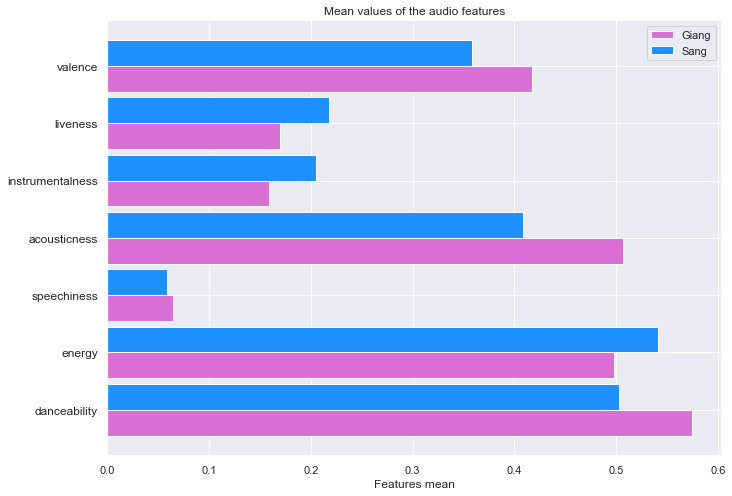

In [19]:
sns.set(rc={'figure.figsize':(11,8)})

#length of giang features
n = len(giang_features.mean())

#list of features
index = np.arange(n)


#bar plot with Giang list
plt.barh(index, giang_features.mean(), 0.45, label = 'Giang', color = 'orchid')

#bar plot with Sang list
plt.barh(index + 0.45, sang_features.mean(), 0.45, label='Sang', color = 'dodgerblue')

#x-label
plt.xlabel('Features mean', fontsize=12)

#y-label
plt.yticks(index + 0.45 / 2, (list(sang_features)[:]), fontsize = 12)

#title
plt.title('Mean values of the audio features')

#legend
plt.legend(loc='best')

#set style
style.use('ggplot')

plt.show


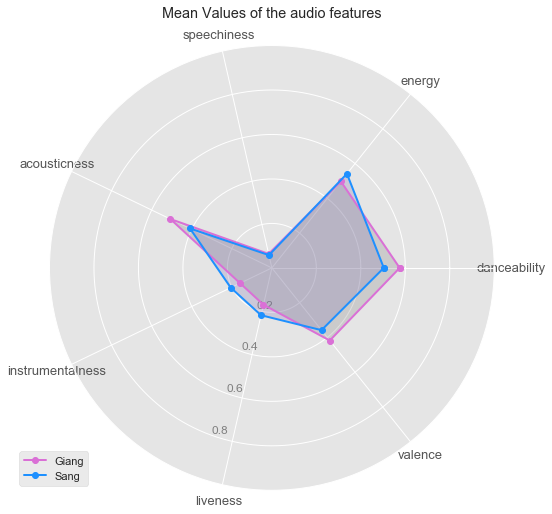

In [20]:
labels= list(giang_features)[:]
stats= giang_features.mean().tolist()
stats2 = sang_features.mean().tolist()

angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)

# close the plot
stats=np.concatenate((stats,[stats[0]]))
stats2 =np.concatenate((stats2,[stats2[0]])) 
angles=np.concatenate((angles,[angles[0]]))

#Size of the figure
fig=plt.figure(figsize = (18,18))

ax = fig.add_subplot(221, polar=True)
ax.plot(angles, stats, 'o-', linewidth=2, label = "Giang", color= 'orchid')
ax.fill(angles, stats, alpha=0.25, facecolor='gray')
ax.set_thetagrids(angles * 180/np.pi, labels , fontsize = 13)


ax.set_rlabel_position(250)
plt.yticks([0.2 , 0.4 , 0.6 , 0.8  ], ["0.2",'0.4', "0.6", "0.8"], color="grey", size=12)
plt.ylim(0,1)

ax.plot(angles, stats2, 'o-', linewidth=2, label = "Sang", color = 'dodgerblue')
ax.fill(angles, stats2, alpha=0.25, facecolor='m' )
ax.set_title('Mean Values of the audio features')
ax.grid(True)

plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))



We can see that we have similar taste for music. However, my songs carry more acousticness, danceability and valence (positivity) than Sang, while his songs are more lively, energetic and instrumental.

Tempo and loudness can also be important factors in audio features. We will look at how our songs differ by these 2 variables:

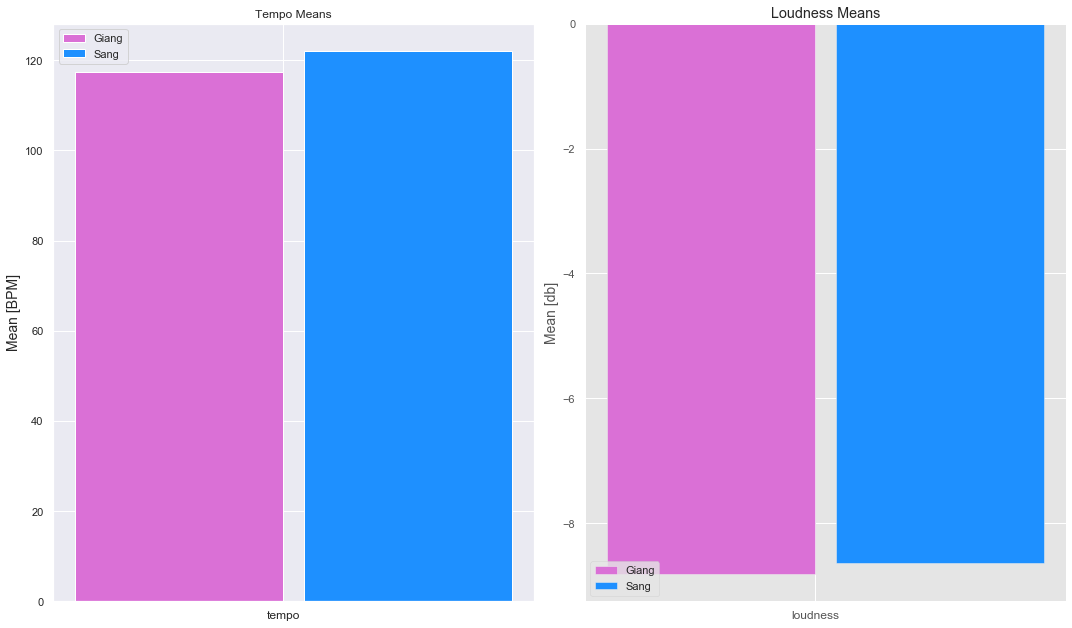

In [21]:
tempo_giang = giang_playlist[['tempo']]
tempo_sang = sang_playlist[['tempo']]

sns.set(rc={'figure.figsize':(15,17)})

N = len(tempo_giang.mean())

ind = np.arange(N) 

plt.subplot(221)
width = 0.35      
plt.bar(ind, tempo_giang.mean() , width, label='Giang', color = 'orchid')
plt.bar(ind + 1.1*width, tempo_sang.mean(), width, label='Sang', color = 'dodgerblue')

plt.ylabel('Mean [BPM]', fontsize = 14)
plt.title('Tempo Means')

plt.xticks(ind + width / 2, (list(tempo_giang)[:]), fontsize = 12)
plt.legend(loc='best')
style.use("ggplot")


plt.subplot(222)

loud_giang = giang_playlist[['loudness']]
loud_sang = sang_playlist[['loudness']]

N = len(loud_giang.mean())

ind = np.arange(N) 

width = 0.35      
plt.bar(ind, loud_giang.mean() , width, label='Giang', color = 'orchid')
plt.bar(ind + 1.1*width, loud_sang.mean(), width, label='Sang', color = 'dodgerblue')

plt.ylabel('Mean [db]', fontsize = 14)
plt.title('Loudness Means')



plt.xticks(ind + width / 2, (list(loud_giang)[:]), fontsize = 12)
plt.legend(loc='lower left')
style.use("ggplot")

plt.tight_layout()
plt.show()

We can observe that our songs are closed to 120BMP, which indicates that both of us like listening to fast and energetic songs. 

It is also brutal to look at the difference between the mean of each attribute of mine and Sang’s songs.

According to the bar chart bellow, we can see clearly that my list is more acoustic, danceable and valence than his. Besides, we can also notice a slight difference in our speechiness variables and see that energy, instrumentalness, and liveliness take the top spot on his list.


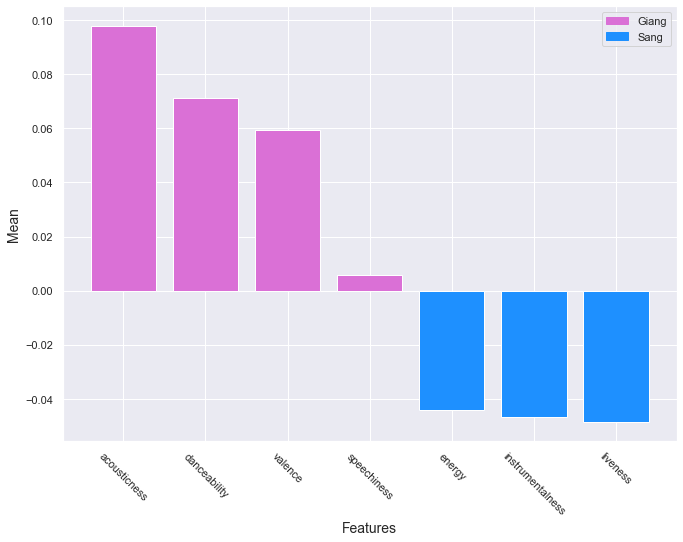

In [22]:
colors = ['orchid','orchid','orchid', 'orchid',
          'dodgerblue','dodgerblue','dodgerblue']

sns.set(rc={'figure.figsize':(11,8)})


dif_features = giang_features.mean() - sang_features.mean()

index = dif_features.sort_values(ascending = False).index

#Plot
fig, ax = plt.subplots()
x = np.arange(dif_features.count())
y = dif_features.sort_values(ascending = False)
plt.bar(x,y, color = colors)
plt.xticks(x, (giang_features.columns))
ax.set_xticklabels(index, rotation=-45)



#Create Legend
import matplotlib.patches as mpatches
orchid_patch = mpatches.Patch(color ='orchid', label = 'Giang')
blue_patch = mpatches.Patch(color = 'dodgerblue', label = 'Sang')
plt.legend(handles = [orchid_patch,blue_patch], loc = 'upper right')

#labels
plt.ylabel('Mean', fontsize = 14)
plt.xlabel('Features', fontsize = 14)
plt.show()

How diverse are our songs?

In [23]:
sang_features.std().mean()

0.23762811174550502

In [24]:
giang_features.std().mean()

0.22151655735477083

We can see that Sang's choice of songs are more diverse than mine.

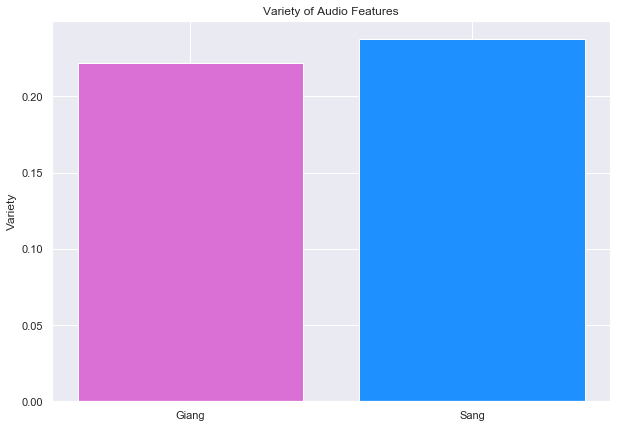

In [25]:
sns.set(rc={'figure.figsize':(10,7)})


data = [giang_features.std().mean(), sang_features.std().mean()]
names = ('Giang','Sang')
pos = np.arange(len(names))
colors = ['orchid', 'dodgerblue']

plt.bar(pos, data, align = 'center', color = colors)
plt.xticks(pos, names)
plt.ylabel('Variety')
plt.title('Variety of Audio Features')
plt.show()


Text(0.5, 1.0, "Standard Deviation of Sang's Audio Features")

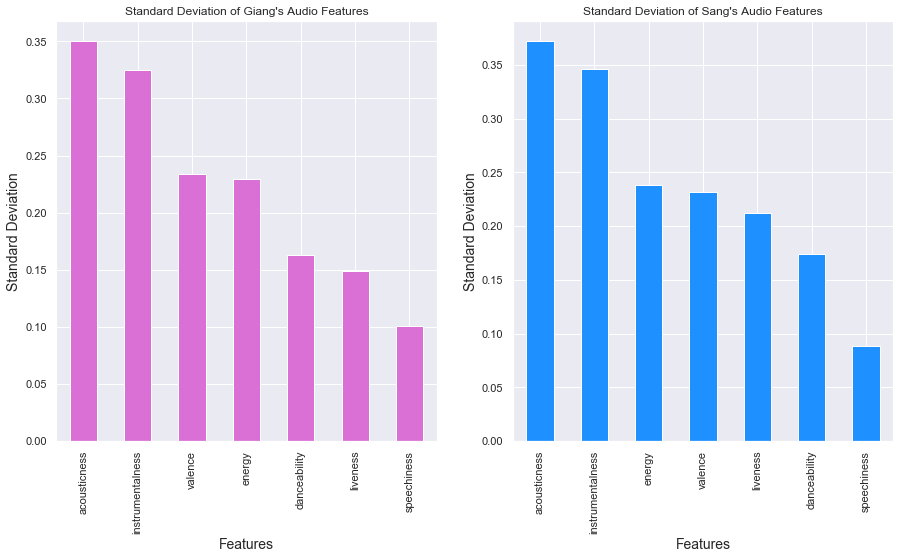

In [26]:
sns.set(rc={'figure.figsize':(15,17)})


plt.subplot(221)

giang_features.std().sort_values(ascending= False).plot(kind = 'bar', color = 'orchid')

plt.xlabel('Features', fontsize = 14)
plt.ylabel('Standard Deviation', fontsize = 14)
plt.title("Standard Deviation of Giang's Audio Features")

plt.subplot(222)
sang_features.std().sort_values(ascending= False).plot(kind = 'bar', color = 'dodgerblue')

plt.xlabel('Features', fontsize = 14)
plt.ylabel('Standard Deviation', fontsize = 14)
plt.title("Standard Deviation of Sang's Audio Features")


Even though my songs are my acoustic, valance and lively than Sang's list, his songs are more varied in these features than mine.

### Finding correlation between variables

In [27]:
couple_feature = giang_playlist.append(sang_playlist)

#### Correlation plot

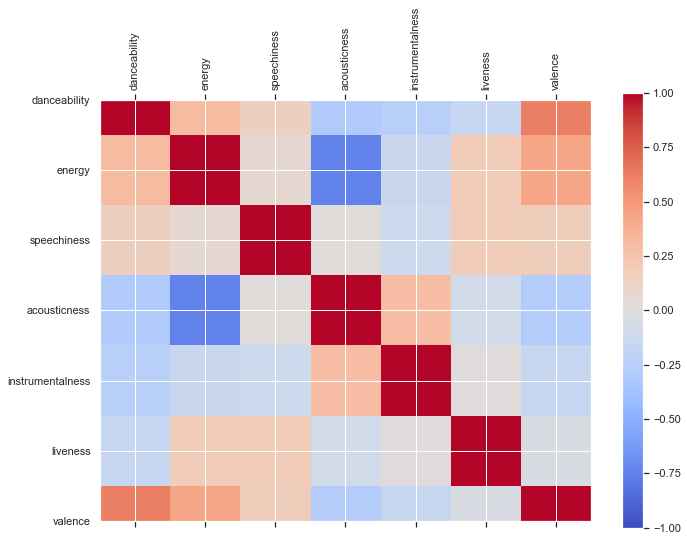

In [28]:
sns.set(rc={'figure.figsize':(11,8)})


#app usage variables
X = couple_feature[['danceability', 'energy', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence']]

#correlation for variables in X
corr = X.corr()

#Plot the correlation
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(X.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(X.columns)
ax.set_yticklabels(X.columns)
plt.show()

#### Valence and Energy

In [29]:
from sklearn import metrics
import statsmodels.api as sm

#construct the OLS model
X =  couple_feature['valence']
y = couple_feature['energy']

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 energy   R-squared (uncentered):                   0.759
Model:                            OLS   Adj. R-squared (uncentered):              0.758
Method:                 Least Squares   F-statistic:                              4112.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):                        0.00
Time:                        00:22:57   Log-Likelihood:                         -195.75
No. Observations:                1309   AIC:                                      393.5
Df Residuals:                    1308   BIC:                                      398.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
valence        1.1054      0.017     64.123      0.000       1.072       1.139
==============================================================================
Omnibus:                        1.041   Durbin-Watson:                   1.185
Prob(Omnibus):                  0.594   Jarque-Bera (JB):                1.083
Skew:                           0.023   Prob(JB):                        0.582
Kurtosis:                       2.867   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

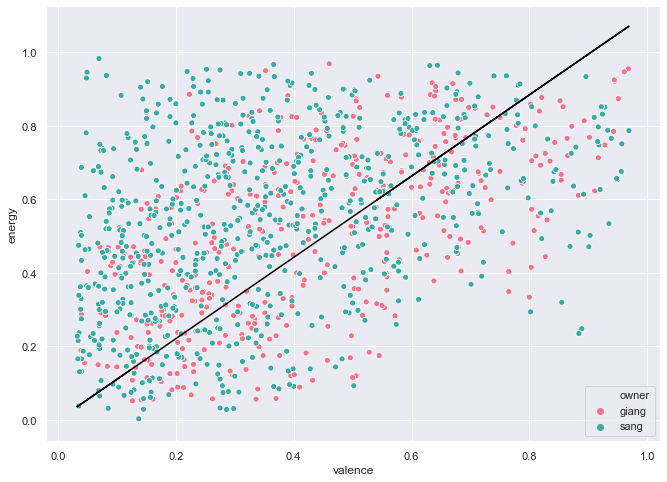

In [30]:
sns.set(rc={'figure.figsize':(11,8)})


sns.scatterplot(x="valence", y="energy", hue="owner",palette="husl",
                     data=couple_feature)

plt.plot(X, predictions, color='black')


#### Valence and Danceability

In [31]:
#construct the OLS model
X =  couple_feature['valence']
y = couple_feature['danceability']

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           danceability   R-squared (uncentered):                   0.833
Model:                            OLS   Adj. R-squared (uncentered):              0.833
Method:                 Least Squares   F-statistic:                              6524.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):                        0.00
Time:                        00:22:57   Log-Likelihood:                          66.162
No. Observations:                1309   AIC:                                     -130.3
Df Residuals:                    1308   BIC:                                     -125.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
valence        1.1399      0.014     80.773      0.000       1.112       1.168
==============================================================================
Omnibus:                       13.585   Durbin-Watson:                   1.539
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.869
Skew:                          -0.245   Prob(JB):                     0.000974
Kurtosis:                       2.878   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

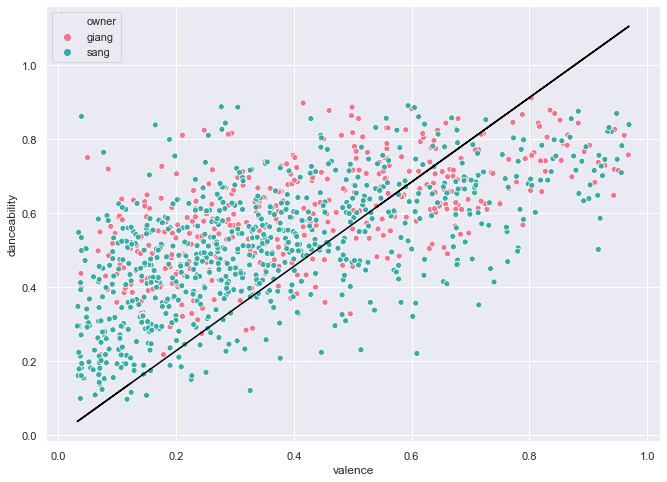

In [32]:
sns.scatterplot(x="valence", y="danceability", hue="owner", palette="husl",
                     data=couple_feature)

plt.plot(X, predictions, color='black')


## Machine Learning approach

So what is the most predictive metrics that can predict which songs are more likely to be listened by me or Sang?


In [33]:
#Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, make_scorer

#feature selection
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold


#feature scaling
from sklearn.preprocessing import StandardScaler

#Gridsearch for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor

#logistics regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm

#K-Nearest Neighbor
from sklearn.neighbors import KNeighborsClassifier

#SVM
from sklearn.svm import SVC

#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#seed
import random

#Address imbalance data using SMOTE package
from imblearn.over_sampling import SMOTE


# Normalizing continuous variables
from sklearn.preprocessing import MinMaxScaler


In [34]:
giang_playlist1 = giang_playlist.copy()
sang_playlist1 = sang_playlist.copy()

giang_playlist1['owner']  = 1
sang_playlist1['owner']  = 0

couple_feature1 = giang_playlist1.append(sang_playlist1)
couple_feature1.columns


Index(['owner', 'artist_name', 'album_release_date', 'album_release_year',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'explicit', 'is_local', 'track_name', 'type',
       'album_name', 'key_name'],
      dtype='object')

We can see there is a small imbalance class problem here:

In [35]:
couple_feature1.owner.value_counts()

0    714
1    595
Name: owner, dtype: int64

We can solve this by up-sampling method:

In [36]:
#Split between explain and response variables
X = couple_feature1[['danceability','energy', 'loudness', 'speechiness', 'acousticness',
                   'instrumentalness', 'liveness', 'valence', 'tempo']]
y = couple_feature1[['owner']]

#resampling data
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['owner'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of sang's song in oversampled data are",len(os_data_y[os_data_y['owner']==0]))
print("Number of giang's song are",len(os_data_y[os_data_y['owner']==1]))
print("Proportion of sang's data in oversampled data is ",len(os_data_y[os_data_y['owner']==0])/len(os_data_X))
print("Proportion of giang's data in oversampled data is ",len(os_data_y[os_data_y['owner']==1])/len(os_data_X))



length of oversampled data is  1004
Number of sang's song in oversampled data are 502
Number of giang's song are 502
Proportion of sang's data in oversampled data is  0.5
Proportion of giang's data in oversampled data is  0.5


/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
#take response and explain date from balanced dataset
X=os_data_X[['danceability','energy', 'loudness', 'speechiness', 'acousticness',
                   'instrumentalness', 'liveness', 'valence', 'tempo']]


y=os_data_y[['owner']]


predict_labels = ['danceability','energy', 'loudness', 'speechiness', 'acousticness',
                   'instrumentalness', 'liveness', 'valence', 'tempo']

#train test split
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(os_data_X, os_data_y, test_size=0.4, random_state=0)



### Feature Important using Random Forest

Since we can see in the correlation plot early, there is a collinearity problem. Therefore, we can consider applying Random Forest to discover feature important over other methods.

In [38]:
random.seed(123)


#Now we find the best parameters to fit in the Random Forest model, we will use it to measure the feature important in the data

#RF model
rf = RandomForestClassifier()

# Train the classifier
rf.fit(X_train_rf, y_train_rf)

y_pred_rf = rf.predict(X_test_rf)

# Print the name and gini importance of each feature
for feature in zip(predict_labels, rf.feature_importances_):
    print(feature)
    

('danceability', 0.14002790853807548)
('energy', 0.1016424390548984)
('loudness', 0.10379353594008493)
('speechiness', 0.10530357788244282)
('acousticness', 0.12216303907925004)
('instrumentalness', 0.08779619946206937)
('liveness', 0.12839443311790275)
('valence', 0.1208261062067382)
('tempo', 0.09005276071853803)


/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


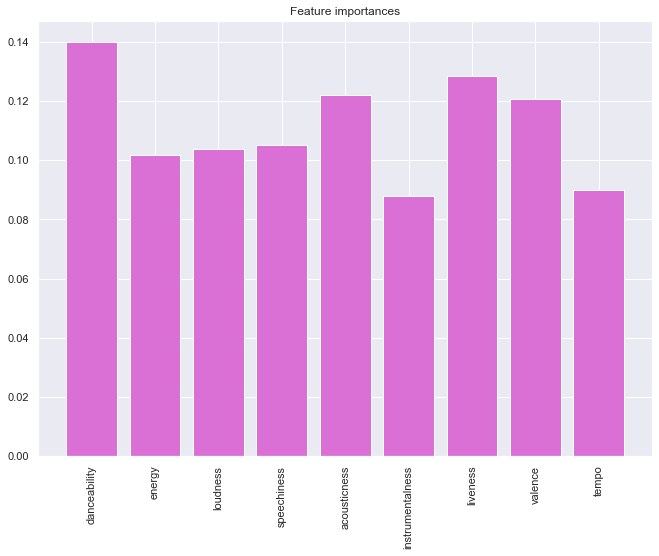

In [39]:
plt.figure()

plt.title("Feature importances")

plt.bar(predict_labels,rf.feature_importances_, align="center", color='orchid')

plt.xticks(predict_labels)

plt.xticks(rotation=90)

plt.show()

**Acousticness, energy, danceability, loudness, liveness, valence and tempo are the most predictive features for song classification.**

After finding the most predictive covariates, we will try different classification models to determine which one can best perform in predicting which song is more likely to be listened by me or Sang according to our audio features.

### Fitting models

#### Random Forest

In [40]:
random.seed(123)


#take response and explain date from balanced dataset
X=os_data_X[['danceability', 'acousticness', 'energy',
                   'loudness', 'liveness', 'valence','tempo']]


y=os_data_y[['owner']]


predict_labels = ['danceability', 'acousticness', 'energy'
                   'loudness', 'liveness', 'valence','tempo']

#train test split
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(os_data_X, os_data_y, test_size=0.4, random_state=0)

#Now we find the best parameters to fit in the Random Forest model, we will use it to measure the feature important in the data

#RF model
rf = RandomForestClassifier()
    
# Train the classifier

rf.fit(X_train_rf, y_train_rf)

y_pred_rf = rf.predict(X_test_rf)

/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [41]:
# accuracy: (tp + tn) / (p + n)
accuracy_rf = accuracy_score(y_test_rf, y_pred_rf)
print('Accuracy: %f' % accuracy_rf)

# precision tp / (tp + fp)
precision_rf = precision_score(y_test_rf, y_pred_rf)
print('Precision: %f' % precision_rf)

# recall: tp / (tp + fn)
recall_rf = recall_score(y_test_rf, y_pred_rf)
print('Recall: %f' % recall_rf)

# f1: 2 tp / (2 tp + fp + fn)
f1_rf = f1_score(y_test_rf, y_pred_rf)
print('F1 score: %f' % f1_rf)

# ROC AUC
auc_rf = roc_auc_score(y_test_rf, y_pred_rf)
print('ROC AUC: %f' % auc_rf)

Accuracy: 0.579602
Precision: 0.579235
Recall: 0.535354
F1 score: 0.556430
ROC AUC: 0.578951


#### Logistic Regression

In [42]:
random.seed(123)

# implement the model

#train test split
X_train_logit, X_test_logit, y_train_logit, y_test_logit = train_test_split(os_data_X, os_data_y, test_size=0.4, random_state=0)

# train the model
logreg = LogisticRegression()
logreg.fit(X_train_logit, y_train_logit)

y_pred_logit = logreg.predict(X_test_logit)


/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [43]:
# accuracy: (tp + tn) / (p + n)
accuracy_logit = accuracy_score(y_test_logit, y_pred_logit)
print('Accuracy: %f' % accuracy_logit)

# precision tp / (tp + fp)
precision_logit = precision_score(y_test_logit, y_pred_logit)
print('Precision: %f' % precision_logit)

# recall: tp / (tp + fn)
recall_logit = recall_score(y_test_logit, y_pred_logit)
print('Recall: %f' % recall_logit)

# f1: 2 tp / (2 tp + fp + fn)
f1_logit = f1_score(y_test_logit, y_pred_logit)
print('F1 score: %f' % f1_logit)

# ROC AUC
auc_logit = roc_auc_score(y_test_logit, y_pred_logit)
print('ROC AUC: %f' % auc_logit)

Accuracy: 0.634328
Precision: 0.619718
Recall: 0.666667
F1 score: 0.642336
ROC AUC: 0.634804


#### Linear Discrimination Analysis (LDA)

In [44]:
random.seed(123)


#train test split
X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(os_data_X, os_data_y, test_size=0.4, random_state=0)

lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_lda, y_train_lda)
X_test_lda = lda.transform(X_test_lda)


ldaclassifier = RandomForestClassifier(max_depth=2, random_state=0)

ldaclassifier.fit(X_train_lda, y_train_lda)
y_pred_lda = ldaclassifier.predict(X_test_lda)

/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [45]:
# accuracy: (tp + tn) / (p + n)
accuracy_lda = accuracy_score(y_test_lda, y_pred_lda)
print('Accuracy: %f' % accuracy_lda)

# precision tp / (tp + fp)
precision_lda = precision_score(y_test_lda, y_pred_lda)
print('Precision: %f' % precision_lda)

# recall: tp / (tp + fn)
recall_lda = recall_score(y_test_lda, y_pred_lda)
print('Recall: %f' % recall_lda)

# f1: 2 tp / (2 tp + fp + fn)
f1_lda = f1_score(y_test_lda, y_pred_lda)
print('F1 score: %f' % f1_lda)

# ROC AUC
auc_lda = roc_auc_score(y_test_lda, y_pred_lda)
print('ROC AUC: %f' % auc_lda)

Accuracy: 0.631841
Precision: 0.614679
Recall: 0.676768
F1 score: 0.644231
ROC AUC: 0.632501


In [46]:
# ROC AUC curve

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_rf, rf.predict_proba(X_test_rf)[:,1])
fpr_logit, tpr_logit, thresholds_logit = roc_curve(y_test_logit, logreg.predict_proba(X_test_logit)[:,1])
fpr_lda, tpr_lda, thresholds_lda = roc_curve(y_test_lda, ldaclassifier.predict_proba(X_test_lda)[:,1])



We will combine the Accuracy, precision, recall, F1, AUC in one table for easier comparision of these classifiers.

In [47]:
result_table = pd.DataFrame(columns=['classifier','accuracy','precision','recall','f1','auc','fpr','tpr'])

result_table = result_table.append({'classifier':'RandomForest','accuracy':accuracy_rf,
                                    'precision':precision_rf,'recall':recall_rf,
                                    'f1':f1_rf,'auc':auc_rf,'fpr':fpr_rf, 'tpr':tpr_rf}, ignore_index=True)
result_table = result_table.append({'classifier':'LogisticRegression','accuracy':accuracy_logit,
                                    'precision':precision_logit,'recall':recall_logit,
                                    'f1':f1_rf,'auc':auc_logit,'fpr':fpr_logit, 'tpr':tpr_logit}, ignore_index=True)
result_table = result_table.append({'classifier':'LDA','accuracy':accuracy_lda,
                                    'precision':precision_lda,'recall':recall_lda,
                                    'f1':f1_lda,'auc':auc_lda,'fpr':fpr_lda, 'tpr':tpr_lda}, ignore_index=True)

result_table.set_index('classifier', inplace=True)

result_table

,accuracy,precision,recall,f1,auc,fpr,tpr
classifier,,,,,,,
RandomForest,0.579602,0.579235,0.535354,0.556430,0.578951,"[0.0, 0.024509803921568627, 0.0343137254901960...","[0.0, 0.010101010101010102, 0.0101010101010101..."
LogisticRegression,0.634328,0.619718,0.666667,0.556430,0.634804,"[0.0, 0.004901960784313725, 0.0147058823529411...","[0.0, 0.0, 0.0, 0.005050505050505051, 0.005050..."
LDA,0.631841,0.614679,0.676768,0.644231,0.632501,"[0.0, 0.0196078431372549, 0.16666666666666666,...","[0.0, 0.015151515151515152, 0.3181818181818182..."


We will plot out the ROC curve to visualize and compare between classifers.

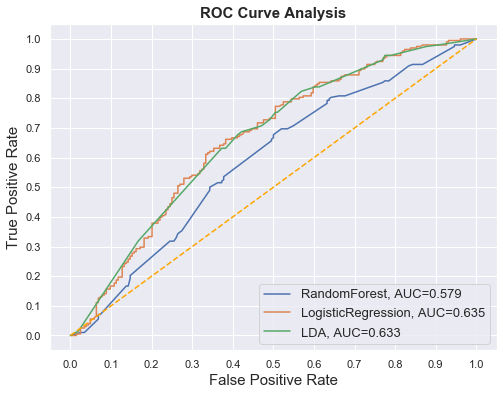

In [48]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

We can see that Logistic Regression (LR) out-perform all other models in terms of accuracy, precision and recall score. 
Furthermore, we see that LR also has the highest True Positive/False Positive ratio as depicted in the ROC chart. 

--> We will pick LR as our best-performing model for this task and we can go ahead to tune the model to further improve its performance.

### Fine tune Logistic Regression

In [49]:
random.seed(123)


#train test split
X_train_logit, X_test_logit, y_train_logit, y_test_logit = train_test_split(os_data_X, os_data_y, test_size=0.4, random_state=0)


#generate random grid with l2 penalty
grid={"C":np.logspace(0.01,0.001,10,100,1000), "penalty":["l2"]}# l2 ridge
logreg=LogisticRegression(solver='lbfgs')
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(X_train_logit,y_train_logit)

#choosing the best parameters
logreg_cv.best_params_,logreg_cv.best_score_


/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=

/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=

({'C': 1.0715193052376064, 'penalty': 'l2'}, 0.6196013289036545)

In [50]:
random.seed(123)

# train the model
logreg = LogisticRegression(C=1.0715193052376064, penalty = 'l2')
logreg.fit(X_train_logit, y_train_logit)

y_pred_logit = logreg.predict(X_test_logit)

/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
# accuracy: (tp + tn) / (p + n)
accuracy_tune = accuracy_score(y_test_logit, y_pred_logit)
print('Accuracy: %f' % accuracy_tune)

# precision tp / (tp + fp)
precision_tune = precision_score(y_test_logit, y_pred_logit)
print('Precision: %f' % precision_tune)

# recall: tp / (tp + fn)
recall_tune = recall_score(y_test_logit, y_pred_logit)
print('Recall: %f' % recall_tune)

# f1: 2 tp / (2 tp + fp + fn)
f1_tune = f1_score(y_test_logit, y_pred_logit)
print('F1 score: %f' % f1_tune)

# ROC AUC
auc_tune = roc_auc_score(y_test_logit, y_pred_logit)
print('ROC AUC: %f' % auc_tune)

Accuracy: 0.634328
Precision: 0.619718
Recall: 0.666667
F1 score: 0.642336
ROC AUC: 0.634804


In [52]:
fpr_tune, tpr_tune, thresholds_tune = roc_curve(y_test_rf, rf.predict_proba(X_test_rf)[:,1])

result_table = result_table.reset_index()

result_table = result_table.append({'classifier':'Tuned_LogisticRegression','accuracy':accuracy_tune,
                                    'precision':precision_tune,'recall':recall_tune,
                                    'f1':f1_tune,'auc':auc_tune,'fpr':fpr_tune, 'tpr':tpr_tune}, ignore_index=True)

result_table

,classifier,accuracy,precision,recall,f1,auc,fpr,tpr
0,RandomForest,0.579602,0.579235,0.535354,0.556430,0.578951,"[0.0, 0.024509803921568627, 0.0343137254901960...","[0.0, 0.010101010101010102, 0.0101010101010101..."
1,LogisticRegression,0.634328,0.619718,0.666667,0.556430,0.634804,"[0.0, 0.004901960784313725, 0.0147058823529411...","[0.0, 0.0, 0.0, 0.005050505050505051, 0.005050..."
2,LDA,0.631841,0.614679,0.676768,0.644231,0.632501,"[0.0, 0.0196078431372549, 0.16666666666666666,...","[0.0, 0.015151515151515152, 0.3181818181818182..."
3,Tuned_LogisticRegression,0.634328,0.619718,0.666667,0.642336,0.634804,"[0.0, 0.024509803921568627, 0.0343137254901960...","[0.0, 0.010101010101010102, 0.0101010101010101..."


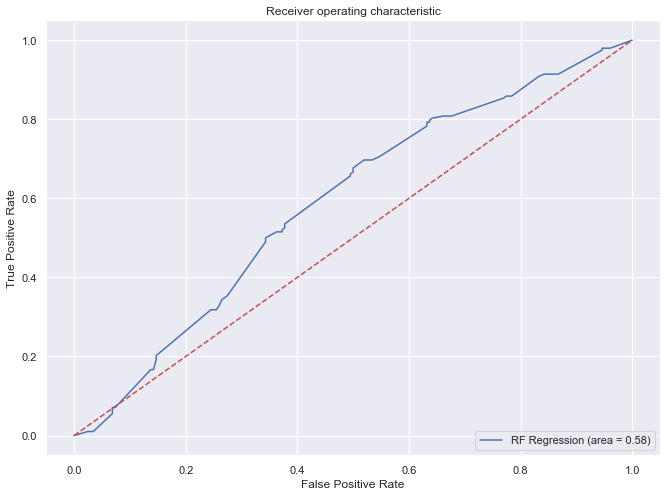

In [53]:
rf_roc_auc = roc_auc_score(y_test_rf, y_pred_rf)
fpr, tpr, thresholds = roc_curve(y_test_rf, rf.predict_proba(X_test_rf)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RF Regression (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Even after tuning the model using Grid Search method, we don't see much improvement. Therefore, we can keep it simple by using the original model with default hyperparameters.

# Movie Analysis

### Imdb movies dataset

You can download them here:
https://www.imdb.com/interfaces/

**title.akas.tsv** - Contains the following information for titles:

- titleId (string) - a tconst, an alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given titleId
- title (string) – the localized title
- region (string) - the region for this version of the title
- language (string) - the language of the title
- types (array) - Enumerated set of attributes for this alternative title. One or more of the following: "alternative", "dvd", "festival", "tv", "video", "working", "original", "imdbDisplay". New values may be added in the future without warning
- attributes (array) - Additional terms to describe this alternative title, not enumerated
- isOriginalTitle (boolean) – 0: not original title; 1: original title

**title.basics.tsv** - Contains the following information for titles:
- tconst (string) - alphanumeric unique identifier of the title
- titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
- primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
- originalTitle (string) - original title, in the original language
- isAdult (boolean) - 0: non-adult title; 1: adult title
- startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year
- endYear (YYYY) – TV Series end year. ‘\N’ for all other title types
- runtimeMinutes – primary runtime of the title, in minutes
- genres (string array) – includes up to three genres associated with the title

**title.ratings.tsv** – Contains the IMDb rating and votes information for titles
- tconst (string) - alphanumeric unique identifier of the title
- averageRating – weighted average of all the individual user ratings
- numVotes - number of votes the title has received

## Importing Data

In [54]:
mov_demo = pd.read_table('imdb/title.akas.tsv')
mov_genre = pd.read_table('imdb/title.basics.tsv')
mov_rating = pd.read_table('imdb/title.ratings.tsv')

/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [55]:
mov_demo = mov_demo.loc[mov_demo['region']=='US']
mov_demo.head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
3,tt0000001,4,Carmencita,US,\N,\N,\N,0
11,tt0000002,6,The Clown and His Dogs,US,\N,\N,literal English title,0
27,tt0000005,1,Blacksmithing Scene,US,\N,alternative,\N,0
30,tt0000005,4,Blacksmith Scene #1,US,\N,alternative,\N,0
31,tt0000005,5,Blacksmithing,US,\N,\N,informal alternative title,0


In [56]:
mov_demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888640 entries, 3 to 19729682
Data columns (total 8 columns):
titleId            888640 non-null object
ordering           888640 non-null int64
title              888640 non-null object
region             888640 non-null object
language           888640 non-null object
types              888640 non-null object
attributes         888640 non-null object
isOriginalTitle    888640 non-null object
dtypes: int64(1), object(7)
memory usage: 61.0+ MB


In [57]:
mov_genre.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,\N,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [58]:
mov_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6393236 entries, 0 to 6393235
Data columns (total 9 columns):
tconst            object
titleType         object
primaryTitle      object
originalTitle     object
isAdult           int64
startYear         object
endYear           object
runtimeMinutes    object
genres            object
dtypes: int64(1), object(8)
memory usage: 439.0+ MB


In [59]:
mov_rating.head()

,tconst,averageRating,numVotes
0,tt0000001,5.6,1557
1,tt0000002,6.1,187
2,tt0000003,6.5,1220
3,tt0000004,6.2,113
4,tt0000005,6.1,1949


In [60]:
mov_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001377 entries, 0 to 1001376
Data columns (total 3 columns):
tconst           1001377 non-null object
averageRating    1001377 non-null float64
numVotes         1001377 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 22.9+ MB


### Netflix viewing history data

You can also retrieved it here: https://www.netflix.com/ViewingActivity

A caveat for this dataset is that while the dataset technically contains all titles you've watched on Netflix, it does not keep records of repeat viewings. For example, when I rewatched "Stranger Things" in December 2019, my original June viewing was replaced by the December one in the dataset.


In [61]:
giang_mov = pd.read_csv('Netflix/NetflixViewingHistory_Giang.csv')
sang_mov = pd.read_csv('Netflix/NetflixViewingHistory_Sang.csv')

In [62]:
giang_mov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 2 columns):
Title    111 non-null object
Date     111 non-null object
dtypes: object(2)
memory usage: 1.9+ KB


In [63]:
sang_mov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 2 columns):
Title    281 non-null object
Date     281 non-null object
dtypes: object(2)
memory usage: 4.5+ KB


In [64]:
giang_mov.head()

,Title,Date
0,Friends: Season 6: The One with the Routine,12/13/19
1,Inheritors: Season 1: Episode 3,12/13/19
2,Marriage Story,12/13/19
3,Inheritors: Season 1: Episode 7,12/11/19
4,Inheritors: Season 1: Episode 10,12/11/19


In [65]:
sang_mov.head()

,Title,Date
0,6 Underground,12/14/19
1,The Irishman,12/13/19
2,"Bikram: Yogi, Guru, Predator",12/1/19
3,Geostorm,11/23/19
4,War Machine,11/16/19


## Clean Data

We will first rename TV series into their original names

#### Sang


In [66]:
sang_mov = sang_mov.replace([np.array(sang_mov[sang_mov["Title"].str.startswith('Suits')]['Title'])],'Suits')

# I will do the same for other titles

In [67]:
sang_mov.Title.unique()

array(['6 Underground', 'The Irishman', 'Bikram: Yogi, Guru, Predator',
       'Geostorm', 'War Machine', 'Vagabond', 'The Game Changers',
       'The Social Network', 'Greatest Events of WWII in Colour',
       'The King', 'Get Smart', 'Seven', 'The Laundromat', 'Explained',
       'Inferno', 'Newness', 'The Da Vinci Code', 'Friends', 'Zombieland',
       'Batman Begins', 'In the Tall Grass', 'In the Shadow of the Moon',
       'Jackpot', 'Shark Tank', 'Joshua: Teenager vs. Superpower',
       'Abstract', 'Seven Years in Tibet', 'The Naked Director',
       'Dynasty', "Inside Bill's Brain: Decoding Bill Gates",
       'Fool for Love', 'The Dark Tower', 'World War Z', 'Escape Room',
       'The Legend of Tarzan', 'Kardec', 'The Family', 'Love',
       'Street Food', 'Dark Tourist', 'Falling Inn Love',
       'The Mummy: Tomb of the Dragon Emperor', 'Operation Finale',
       'First They Killed My Father', 'The Day After Tomorrow', 'Furie',
       'Mindhunter', 'After', 'The Mummy', 'Th

In [68]:
#remove all duplicates
sang_mov.drop_duplicates(subset ="Title", 
                     keep = 'first', inplace = True) 

In [69]:
sang_mov.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 0 to 279
Data columns (total 2 columns):
Title    84 non-null object
Date     84 non-null object
dtypes: object(2)
memory usage: 2.0+ KB


#### Giang

In [70]:
giang_mov = giang_mov.replace([np.array(giang_mov[giang_mov["Title"].str.startswith('Friends')]['Title'])],'Friends')

# I will do the same for other titles

In [71]:
giang_mov.Title.unique()

array(['Friends', 'Inheritors', 'Marriage Story', 'Broken', 'Queer Eye',
       'Bikram: Yogi, Guru, Predator', 'Explained', 'Vagabond',
       "Inside Bill's Brain: Decoding Bill Gates", 'Abstract',
       'Let It Snow', 'Taco Chronicles', 'Living Undocumented',
       'Ali Wong: Baby Cobra', 'The Big Bang Theory', 'Street Food',
       'The Naked Director', 'Money Heist', 'The Great Hack',
       'Ali Wong: Hard Knock Wife', 'Secret Obsession',
       'Spider-Man: Into the Spider-Verse', 'Stranger Things',
       'The Chef Show', 'Memory Games', 'Black Mirror',
       'Always Be My Maybe',
       'Conversations with a Killer: The Ted Bundy Tapes',
       'Tidying Up with Marie Kondo', "Chef's Table", 'The Perfect Date',
       'Our Planet'], dtype=object)

In [72]:
#Remove duplicates
giang_mov.drop_duplicates(subset ="Title", 
                     keep = 'first', inplace = True) 

In [73]:
giang_mov.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 0 to 107
Data columns (total 2 columns):
Title    32 non-null object
Date     32 non-null object
dtypes: object(2)
memory usage: 768.0+ bytes


In [74]:
sang_mov['owner'] = 'sang'
giang_mov['owner'] = 'giang'

### Join the movie dataframes

In [75]:
mov_features = mov_demo.merge(mov_genre,left_on='title',right_on='primaryTitle', how='left')

In [76]:
mov_features = mov_features.merge(mov_rating, left_on = 'tconst', right_on = 'tconst', how= 'left')

In [77]:
mov_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16462270 entries, 0 to 16462269
Data columns (total 19 columns):
titleId            object
ordering           int64
title              object
region             object
language           object
types              object
attributes         object
isOriginalTitle    object
tconst             object
titleType          object
primaryTitle       object
originalTitle      object
isAdult            float64
startYear          object
endYear            object
runtimeMinutes     object
genres             object
averageRating      float64
numVotes           float64
dtypes: float64(3), int64(1), object(15)
memory usage: 2.5+ GB


#### Giang


In [79]:
giang_fea = giang_mov.merge(mov_features, left_on='Title', right_on='title', how = 'left')
giang_fea


,Title,Date,owner,titleId,ordering,title,region,language,types,attributes,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,Friends,12/13/19,giang,tt0002197,3,Friends,US,\N,\N,\N,...,short,Friends,Friends,0.0,1912,\N,17,"Romance,Short,Western",5.6,212.0
1,Friends,12/13/19,giang,tt0002197,3,Friends,US,\N,\N,\N,...,movie,Friends,Druzya,0.0,1939,\N,100,"Biography,War",6.4,17.0
2,Friends,12/13/19,giang,tt0002197,3,Friends,US,\N,\N,\N,...,movie,Friends,Friends,0.0,1971,\N,101,"Drama,Romance",6.6,807.0
3,Friends,12/13/19,giang,tt0002197,3,Friends,US,\N,\N,\N,...,tvSeries,Friends,Friends,0.0,1979,1979,60,"Comedy,Drama",7.2,44.0
4,Friends,12/13/19,giang,tt0002197,3,Friends,US,\N,\N,\N,...,movie,Friends,Friends,0.0,1988,\N,87,"Comedy,Drama",5.9,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40880,Our Planet,4/17/19,giang,tt3300240,3,Our Planet,US,\N,imdbDisplay,\N,...,tvMiniSeries,Our Planet,Our Planet,0.0,2009,\N,\N,Documentary,9.0,58.0
40881,Our Planet,4/17/19,giang,tt3300240,3,Our Planet,US,\N,imdbDisplay,\N,...,tvMiniSeries,Our Planet,Our Planet,0.0,2019,2019,403,Documentary,9.4,19726.0
40882,Our Planet,4/17/19,giang,tt9253866,11,Our Planet,US,\N,imdbDisplay,\N,...,tvMiniSeries,Our Planet,Bokura no chikyû,0.0,2013,\N,110,"Documentary,Reality-TV,Talk-Show",NaN,NaN
40883,Our Planet,4/17/19,giang,tt9253866,11,Our Planet,US,\N,imdbDisplay,\N,...,tvMiniSeries,Our Planet,Our Planet,0.0,2009,\N,\N,Documentary,9.0,58.0


In [80]:
giang_fea = giang_fea.sort_values(['averageRating'],na_position='first')
giang_fea = giang_fea.drop_duplicates(subset='Title',keep='last')
giang_fea = giang_fea.dropna()
giang_fea.head()

,Title,Date,owner,titleId,ordering,title,region,language,types,attributes,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
40512,Secret Obsession,7/18/19,giang,tt9419834,18,Secret Obsession,US,\N,imdbDisplay,\N,...,movie,Secret Obsession,Secret Obsession,0.0,2019,\N,97,"Drama,Mystery,Thriller",4.3,14410.0
40393,Living Undocumented,10/3/19,giang,tt10977486,5,Living Undocumented,US,\N,\N,\N,...,tvSeries,Living Undocumented,Living Undocumented,0.0,2019,\N,45,Documentary,6.1,403.0
40674,Tidying Up with Marie Kondo,5/7/19,giang,tt8115560,15,Tidying Up with Marie Kondo,US,\N,\N,\N,...,tvSeries,Tidying Up with Marie Kondo,Tidying Up with Marie Kondo,0.0,2019,\N,40,Reality-TV,6.6,2292.0
40071,"Bikram: Yogi, Guru, Predator",11/27/19,giang,tt10883004,4,"Bikram: Yogi, Guru, Predator",US,\N,imdbDisplay,\N,...,movie,"Bikram: Yogi, Guru, Predator","Bikram: Yogi, Guru, Predator",0.0,2019,\N,86,"Crime,Documentary",6.7,2189.0
40507,The Great Hack,8/16/19,giang,tt9358204,22,The Great Hack,US,\N,imdbDisplay,\N,...,movie,The Great Hack,The Great Hack,0.0,2019,\N,113,Documentary,7.0,13483.0


In [81]:
#extract a necessary number of columns for analysis purposes
giang_feature = giang_fea[['owner','Title','Date','titleId','region','titleType','startYear','runtimeMinutes',
                          'genres','averageRating','numVotes']]

Split the **'genre'** column by comma and attach them back to the dataframe

In [82]:
giang_genre = pd.concat([giang_feature, giang_feature['genres'].str.split(',', expand=True)], axis=1)
giang_genre = pd.melt(giang_genre, id_vars=['Title'], value_vars=[0,1,2])
giang_genre = giang_genre[['Title','value']]
giang_genre = giang_genre.dropna()
giang_genre.columns = ['Title','genre']
giang_genre.head()

,Title,genre
0,Secret Obsession,Drama
1,Living Undocumented,Documentary
2,Tidying Up with Marie Kondo,Reality-TV
3,"Bikram: Yogi, Guru, Predator",Crime
4,The Great Hack,Documentary


In [83]:
giang_feature = giang_feature.merge(giang_genre, left_on='Title', right_on='Title', how='left').drop(columns='genres')
giang_feature.head()

,owner,Title,Date,titleId,region,titleType,startYear,runtimeMinutes,averageRating,numVotes,genre
0,giang,Secret Obsession,7/18/19,tt9419834,US,movie,2019,97,4.3,14410.0,Drama
1,giang,Secret Obsession,7/18/19,tt9419834,US,movie,2019,97,4.3,14410.0,Mystery
2,giang,Secret Obsession,7/18/19,tt9419834,US,movie,2019,97,4.3,14410.0,Thriller
3,giang,Living Undocumented,10/3/19,tt10977486,US,tvSeries,2019,45,6.1,403.0,Documentary
4,giang,Tidying Up with Marie Kondo,5/7/19,tt8115560,US,tvSeries,2019,40,6.6,2292.0,Reality-TV


#### Sang

In [84]:
sang_fea = sang_mov.merge(mov_features, left_on='Title', right_on='title', how = 'left')
sang_fea

,Title,Date,owner,titleId,ordering,title,region,language,types,attributes,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,6 Underground,12/14/19,sang,tt8106534,10.0,6 Underground,US,\N,imdbDisplay,\N,...,tvEpisode,6 Underground,6 Underground,0.0,2010,\N,\N,Drama,NaN,NaN
1,6 Underground,12/14/19,sang,tt8106534,10.0,6 Underground,US,\N,imdbDisplay,\N,...,movie,6 Underground,6 Underground,0.0,2019,\N,127,"Action,Thriller",6.2,26479.0
2,The Irishman,12/13/19,sang,tt0505941,1.0,The Irishman,US,\N,\N,\N,...,movie,The Irishman,The Irishman,0.0,1978,\N,108,"Drama,Romance",6.3,103.0
3,The Irishman,12/13/19,sang,tt0505941,1.0,The Irishman,US,\N,\N,\N,...,tvEpisode,The Irishman,The Irishman,0.0,1957,\N,26,"Adventure,Western",6.7,7.0
4,The Irishman,12/13/19,sang,tt0505941,1.0,The Irishman,US,\N,\N,\N,...,tvEpisode,The Irishman,The Irishman,0.0,2019,\N,53,Drama,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43370,House of Cards,2/16/19,sang,tt3709068,1.0,House of Cards,US,\N,\N,\N,...,tvEpisode,House of Cards,House of Cards,0.0,2016,\N,\N,Comedy,NaN,NaN
43371,House of Cards,2/16/19,sang,tt3709068,1.0,House of Cards,US,\N,\N,\N,...,tvEpisode,House of Cards,House of Cards,0.0,2018,\N,23,"Adventure,Fantasy",NaN,NaN
43372,House of Cards,2/16/19,sang,tt3709068,1.0,House of Cards,US,\N,\N,\N,...,tvEpisode,House of Cards,House of Cards,0.0,2018,\N,\N,"Comedy,Drama",7.9,16.0
43373,Dragons: Race to the Edge,2/15/19,sang,tt4816058,4.0,Dragons: Race to the Edge,US,\N,imdbDisplay,\N,...,tvSeries,Dragons: Race to the Edge,Dragons: Race to the Edge,0.0,2015,2018,22,"Action,Adventure,Animation",8.3,4040.0


In [85]:
sang_fea = sang_fea.sort_values(['averageRating'],na_position='first')
sang_fea = sang_fea.drop_duplicates(subset='Title',keep='last')
sang_fea = sang_fea.dropna()
sang_fea.head()

,Title,Date,owner,titleId,ordering,title,region,language,types,attributes,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
17,Geostorm,11/23/19,sang,tt1981128,35.0,Geostorm,US,\N,imdbDisplay,\N,...,movie,Geostorm,Geostorm,0.0,2017,\N,109,"Action,Sci-Fi,Thriller",5.3,84494.0
35817,Falling Inn Love,9/1/19,sang,tt9860728,9.0,Falling Inn Love,US,\N,imdbDisplay,\N,...,movie,Falling Inn Love,Falling Inn Love,0.0,2019,\N,98,"Comedy,Romance",5.6,10564.0
35820,The Mummy: Tomb of the Dragon Emperor,8/31/19,sang,tt0859163,27.0,The Mummy: Tomb of the Dragon Emperor,US,\N,\N,\N,...,tvEpisode,The Mummy: Tomb of the Dragon Emperor,The Mummy: Tomb of the Dragon Emperor,0.0,2008,\N,25,"Documentary,Short",6.1,10.0
11408,In the Tall Grass,10/10/19,sang,tt4687108,6.0,In the Tall Grass,US,\N,imdbDisplay,\N,...,movie,In the Tall Grass,In the Tall Grass,0.0,2006,\N,57,Documentary,6.2,5.0
1,6 Underground,12/14/19,sang,tt8106534,10.0,6 Underground,US,\N,imdbDisplay,\N,...,movie,6 Underground,6 Underground,0.0,2019,\N,127,"Action,Thriller",6.2,26479.0


In [86]:
#extract a necessary number of columns for analysis purposes
sang_feature = sang_fea[['owner','Title','Date','titleId','region','titleType','startYear','runtimeMinutes',
                          'genres','averageRating','numVotes']]

Split the **'genre'** column by comma and attach them back to the dataframe

In [87]:
sang_genre = pd.concat([sang_feature, sang_feature['genres'].str.split(',', expand=True)], axis=1)
sang_genre = pd.melt(sang_genre, id_vars=['Title'], value_vars=[0,1,2])
sang_genre = sang_genre[['Title','value']]
sang_genre = sang_genre.dropna()
sang_genre = sang_genre.rename(columns={'value':'genre'})
sang_genre.head()

,Title,genre
0,Geostorm,Action
1,Falling Inn Love,Comedy
2,The Mummy: Tomb of the Dragon Emperor,Documentary
3,In the Tall Grass,Documentary
4,6 Underground,Action


In [88]:
sang_feature = sang_feature.merge(sang_genre, left_on='Title', right_on='Title', how='left').drop(columns='genres')
sang_feature.head()

,owner,Title,Date,titleId,region,titleType,startYear,runtimeMinutes,averageRating,numVotes,genre
0,sang,Geostorm,11/23/19,tt1981128,US,movie,2017,109,5.3,84494.0,Action
1,sang,Geostorm,11/23/19,tt1981128,US,movie,2017,109,5.3,84494.0,Sci-Fi
2,sang,Geostorm,11/23/19,tt1981128,US,movie,2017,109,5.3,84494.0,Thriller
3,sang,Falling Inn Love,9/1/19,tt9860728,US,movie,2019,98,5.6,10564.0,Comedy
4,sang,Falling Inn Love,9/1/19,tt9860728,US,movie,2019,98,5.6,10564.0,Romance


## Data analysis

Text(0.5, 1.0, "Number of Sang's movies by Sang by types")

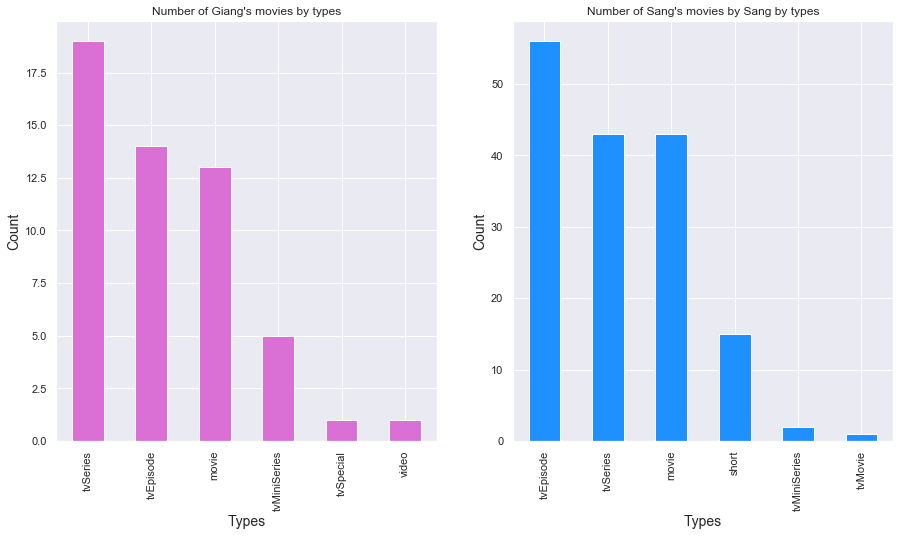

In [89]:
sns.set(rc={'figure.figsize':(15,17)})


plt.subplot(221)

giang_feature.titleType.value_counts().sort_values(ascending= False).plot(kind = 'bar', color = 'orchid')

plt.xlabel('Types', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title("Number of Giang's movies by types")

plt.subplot(222)
sang_feature.titleType.value_counts().sort_values(ascending= False).plot(kind = 'bar', color = 'dodgerblue')

plt.xlabel('Types', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title("Number of Sang's movies by Sang by types")

As we can see from the bar chart, Sang watched more movies and short films than me, while I enjoyed more TV shows/series

Now, I'm curious how many genres in total that I and Sang have, and it seems to be that Sang's movie taste are more varied than mine.

In [90]:
len(giang_genre.genre.unique())

14

In [91]:
len(sang_genre.genre.unique())

21

Text(0.5, 1.0, "Number of Sang's movies by Sang by genres")

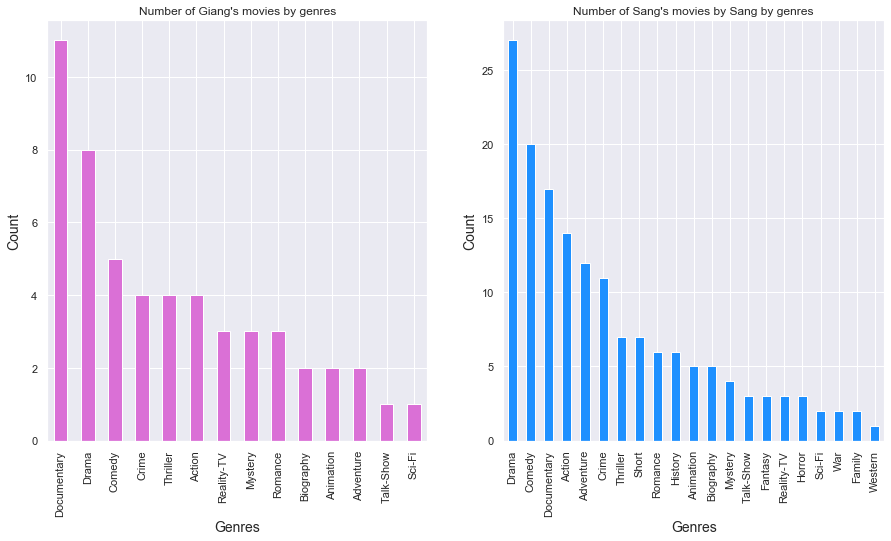

In [92]:
sns.set(rc={'figure.figsize':(15,17)})


plt.subplot(221)

giang_genre.genre.value_counts().sort_values(ascending= False).plot(kind = 'bar', color = 'orchid')

plt.xlabel('Genres', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title("Number of Giang's movies by genres")

plt.subplot(222)
sang_genre.genre.value_counts().sort_values(ascending= False).plot(kind = 'bar', color = 'dodgerblue')

plt.xlabel('Genres', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title("Number of Sang's movies by Sang by genres")

It stood out to me that we have very much similar taste of movie genres where our top 3 are both Documentary, Drama and Comedy. 

Text(0.5, 1.0, "Number of Sang's movies by Sang by genres")

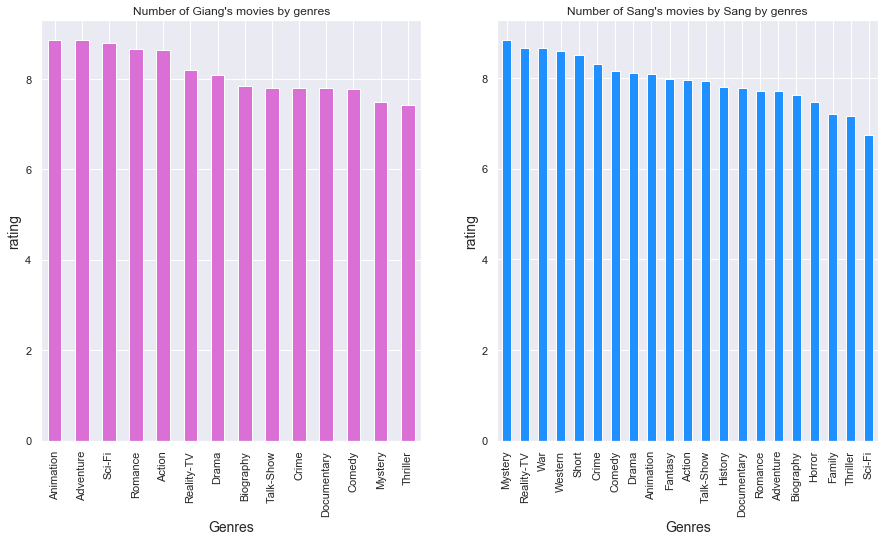

In [93]:
sns.set(rc={'figure.figsize':(15,17)})

plt.subplot(221)

giang_feature.groupby('genre')['averageRating'].mean().sort_values(ascending= False).plot(kind = 'bar', color = 'orchid')

plt.xlabel('Genres', fontsize = 14)
plt.ylabel('rating', fontsize = 14)
plt.title("Number of Giang's movies by genres")

plt.subplot(222)
sang_feature.groupby('genre')['averageRating'].mean().sort_values(ascending= False).plot(kind = 'bar', color = 'dodgerblue')

plt.xlabel('Genres', fontsize = 14)
plt.ylabel('rating', fontsize = 14)
plt.title("Number of Sang's movies by Sang by genres")


Text(0.5, 1.0, "Number of Sang's movies by Sang by genres")

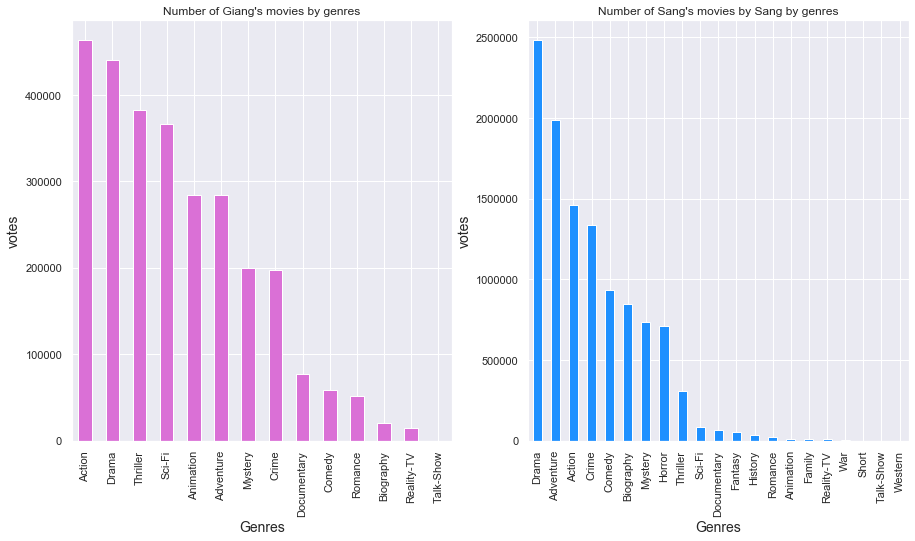

In [94]:
sns.set(rc={'figure.figsize':(15,17)})

plt.subplot(221)

giang_feature.groupby('genre')['numVotes'].sum().sort_values(ascending= False).plot(kind = 'bar', color = 'orchid')

plt.xlabel('Genres', fontsize = 14)
plt.ylabel('votes', fontsize = 14)
plt.title("Number of Giang's movies by genres")

plt.subplot(222)
sang_feature.groupby('genre')['numVotes'].sum().sort_values(ascending= False).plot(kind = 'bar', color = 'dodgerblue')

plt.xlabel('Genres', fontsize = 14)
plt.ylabel('votes', fontsize = 14)
plt.title("Number of Sang's movies by Sang by genres")


## Machine Learning Approach

In [95]:
couple_mov = giang_feature.append(sang_feature)
couple_mov.head()

,owner,Title,Date,titleId,region,titleType,startYear,runtimeMinutes,averageRating,numVotes,genre
0,giang,Secret Obsession,7/18/19,tt9419834,US,movie,2019,97,4.3,14410.0,Drama
1,giang,Secret Obsession,7/18/19,tt9419834,US,movie,2019,97,4.3,14410.0,Mystery
2,giang,Secret Obsession,7/18/19,tt9419834,US,movie,2019,97,4.3,14410.0,Thriller
3,giang,Living Undocumented,10/3/19,tt10977486,US,tvSeries,2019,45,6.1,403.0,Documentary
4,giang,Tidying Up with Marie Kondo,5/7/19,tt8115560,US,tvSeries,2019,40,6.6,2292.0,Reality-TV


In [96]:
couple_mov1 = pd.get_dummies(data=couple_mov,columns=['genre']).groupby(['Title'], as_index=False).sum()
couple_mov1 = couple_mov1.drop(columns=['averageRating','numVotes'])


giang_feature1 = giang_feature.drop_duplicates('Title')
giang_feature1['owner'] = 1
sang_feature1 = sang_feature.drop_duplicates('Title')
sang_feature1['owner'] = 0


couple_mov2 = giang_feature1.append(sang_feature1)

couple_mov1 = couple_mov1.merge(couple_mov2[['owner','Title','titleType',
                               'averageRating','numVotes']],
                                left_on='Title',right_on='Title',how='inner')

couple_mov1 = couple_mov1.drop(columns=['Title'])

couple_mov1 = pd.get_dummies(data=couple_mov1,columns=['titleType'])


couple_mov1

/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,...,averageRating,numVotes,titleType_movie,titleType_short,titleType_tvEpisode,titleType_tvMiniSeries,titleType_tvMovie,titleType_tvSeries,titleType_tvSpecial,titleType_video
0,1,0,0,0,0,0,0,0,0,0,...,6.2,26479.0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,2,0,0,...,8.2,11.0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,2,0,0,...,8.2,11.0,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0,...,9.1,507.0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,7.5,4948.0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,2,0,0,0,0,0,0,0,0,0,...,8.4,1139.0,0,0,0,0,0,1,0,0
105,1,0,0,0,0,0,0,0,0,0,...,8.9,8.0,0,0,0,0,0,1,0,0
106,0,0,0,0,0,0,0,0,0,0,...,6.3,10214.0,0,0,0,0,0,1,0,0
107,0,0,0,0,1,0,0,0,0,0,...,7.6,61.0,0,0,1,0,0,0,0,0


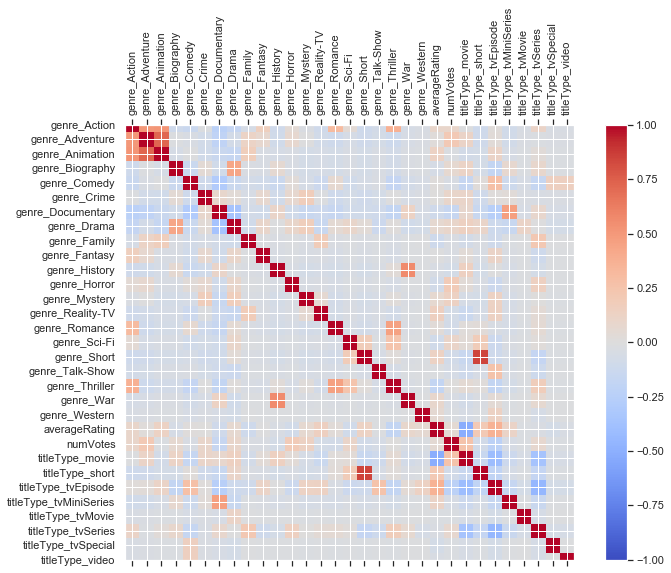

In [97]:
sns.set(rc={'figure.figsize':(11,8)})


#app usage variables
X = couple_mov1.drop(columns='owner')

#correlation for variables in X
corr = X.corr()

#Plot the correlation
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(X.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(X.columns)
ax.set_yticklabels(X.columns)
plt.show()

The variables also highly correlated with each other, so we have a collinearity problem in the movie data as well.

In addition, we can see there is an imbalance class here, let's try solve this problen via up-sampling method

In [98]:
couple_mov1.owner.value_counts()

0    78
1    31
Name: owner, dtype: int64

Using SMOTE package for up-sampling

In [99]:

#Split between explain and response variables
X = couple_mov1.loc[:, couple_mov1.columns != 'owner']
y = couple_mov1.loc[:, couple_mov1.columns == 'owner']

#resampling data
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['owner'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of sang's movies in oversampled data are",len(os_data_y[os_data_y['owner']==0]))
print("Number of giang's movies are",len(os_data_y[os_data_y['owner']==1]))
print("Proportion of sang's data in oversampled data is ",len(os_data_y[os_data_y['owner']==0])/len(os_data_X))
print("Proportion of giang's data in oversampled data is ",len(os_data_y[os_data_y['owner']==1])/len(os_data_X))



length of oversampled data is  96
Number of sang's movies in oversampled data are 48
Number of giang's movies are 48
Proportion of sang's data in oversampled data is  0.5
Proportion of giang's data in oversampled data is  0.5


/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Finding feature important using Random Forest

In [100]:
random.seed(123)


#Now we find the best parameters to fit in the Random Forest model, we will use it to measure the feature important in the data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(os_data_X, os_data_y, test_size=0.3, random_state=0)

predict_labels = os_data_X.columns

#RF model
rf = RandomForestClassifier()

# Train the classifier
rf.fit(X_train_rf, y_train_rf)

y_pred_rf = rf.predict(X_test_rf)

# Print the name and gini importance of each feature
for feature in zip(predict_labels, rf.feature_importances_):
    print(feature)
  

('genre_Action', 0.008575688296058887)
('genre_Adventure', 0.06540300524639112)
('genre_Animation', 0.02600912870336969)
('genre_Biography', 0.004806620656058947)
('genre_Comedy', 0.05665124378868984)
('genre_Crime', 0.014924784917383712)
('genre_Documentary', 0.05977004382366585)
('genre_Drama', 0.04572488657966397)
('genre_Family', 0.008790549136834264)
('genre_Fantasy', 0.0)
('genre_History', 0.03902772890004499)
('genre_Horror', 0.0)
('genre_Mystery', 0.02166437306072282)
('genre_Reality-TV', 0.01703066386663723)
('genre_Romance', 0.02318357669581675)
('genre_Sci-Fi', 0.002778643759244508)
('genre_Short', 0.039563910484135066)
('genre_Talk-Show', 0.006506545437087764)
('genre_Thriller', 0.01367303775866532)
('genre_War', 0.0)
('genre_Western', 0.0)
('averageRating', 0.12654463093055435)
('numVotes', 0.27375198470980067)
('titleType_movie', 0.027247797559856644)
('titleType_short', 0.00472563330474554)
('titleType_tvEpisode', 0.016679685106466408)
('titleType_tvMiniSeries', 0.011705

/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


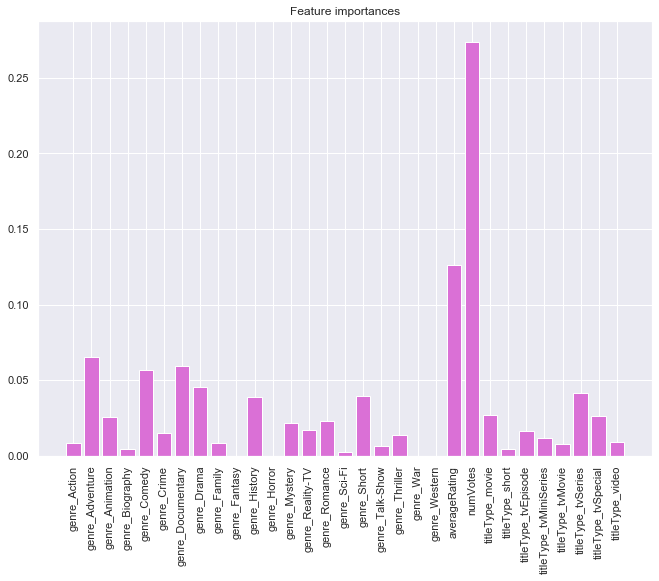

In [101]:
sns.set(rc={'figure.figsize':(11,8)})


plt.figure()

plt.title("Feature importances")

plt.bar(predict_labels,rf.feature_importances_, align="center", color='orchid')

plt.xticks(predict_labels)

plt.xticks(rotation=90)

plt.show()

(1) Action, Adventure, Comedy, Documentary, Drama, reality TV are the most predictive genres, (2) TV series is the most predictive for title type, (3) average Rating and Number of votes are the most predictive covariates for classifying which movie will likely be watch by me or Sang

In [102]:
os_data_X.columns

Index(['genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Biography',
       'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama',
       'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror',
       'genre_Mystery', 'genre_Reality-TV', 'genre_Romance', 'genre_Sci-Fi',
       'genre_Short', 'genre_Talk-Show', 'genre_Thriller', 'genre_War',
       'genre_Western', 'averageRating', 'numVotes', 'titleType_movie',
       'titleType_short', 'titleType_tvEpisode', 'titleType_tvMiniSeries',
       'titleType_tvMovie', 'titleType_tvSeries', 'titleType_tvSpecial',
       'titleType_video'],
      dtype='object')

In [103]:
random.seed(123)

os_data_X = os_data_X[['genre_Action', 'genre_Adventure', 'genre_Comedy',
       'genre_Documentary', 'genre_Drama',
       'genre_Reality-TV', 'averageRating', 'numVotes','titleType_tvSeries']]

#Now we find the best parameters to fit in the Random Forest model, we will use it to measure the feature important in the data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(os_data_X, os_data_y, test_size=0.3, random_state=0)

predict_labels = os_data_X.columns

#RF model
rf = RandomForestClassifier()

# Train the classifier
rf.fit(X_train_rf, y_train_rf)

y_pred_rf = rf.predict(X_test_rf)



/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


In [104]:

# accuracy: (tp + tn) / (p + n)
accuracy_rf = accuracy_score(y_test_rf, y_pred_rf)
print('Accuracy: %f' % accuracy_rf)

# precision tp / (tp + fp)
precision_rf = precision_score(y_test_rf, y_pred_rf)
print('Precision: %f' % precision_rf)

# recall: tp / (tp + fn)
recall_rf = recall_score(y_test_rf, y_pred_rf)
print('Recall: %f' % recall_rf)

# f1: 2 tp / (2 tp + fp + fn)
f1_rf = f1_score(y_test_rf, y_pred_rf)
print('F1 score: %f' % f1_rf)

# ROC AUC
auc_rf = roc_auc_score(y_test_rf, y_pred_rf)
print('ROC AUC: %f' % auc_rf)

Accuracy: 0.620690
Precision: 0.583333
Recall: 0.538462
F1 score: 0.560000
ROC AUC: 0.612981


### LDA

In [105]:
random.seed(123)

#train test split
X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(os_data_X, os_data_y, test_size=0.4, random_state=0)

lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_lda, y_train_lda)
X_test_lda = lda.transform(X_test_lda)


ldaclassifier = RandomForestClassifier(max_depth=2, random_state=0)

ldaclassifier.fit(X_train_lda, y_train_lda)
y_pred_lda = ldaclassifier.predict(X_test_lda)

/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


In [106]:
# accuracy: (tp + tn) / (p + n)
accuracy_lda = accuracy_score(y_test_lda, y_pred_lda)
print('Accuracy: %f' % accuracy_lda)

# precision tp / (tp + fp)
precision_lda = precision_score(y_test_lda, y_pred_lda)
print('Precision: %f' % precision_lda)

# recall: tp / (tp + fn)
recall_lda = recall_score(y_test_lda, y_pred_lda)
print('Recall: %f' % recall_lda)

# f1: 2 tp / (2 tp + fp + fn)
f1_lda = f1_score(y_test_lda, y_pred_lda)
print('F1 score: %f' % f1_lda)

# ROC AUC
auc_lda = roc_auc_score(y_test_lda, y_pred_lda)
print('ROC AUC: %f' % auc_lda)

Accuracy: 0.589744
Precision: 0.551724
Recall: 0.842105
F1 score: 0.666667
ROC AUC: 0.596053


In [107]:
# ROC AUC curve

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_rf, rf.predict_proba(X_test_rf)[:,1])
fpr_lda, tpr_lda, thresholds_lda = roc_curve(y_test_lda, ldaclassifier.predict_proba(X_test_lda)[:,1])



In [108]:
result_table = pd.DataFrame(columns=['classifier','accuracy','precision','recall','f1','auc','fpr','tpr'])

result_table = result_table.append({'classifier':'RandomForest','accuracy':accuracy_rf,
                                    'precision':precision_rf,'recall':recall_rf,
                                    'f1':f1_rf,'auc':auc_rf,'fpr':fpr_rf, 'tpr':tpr_rf}, ignore_index=True)

result_table = result_table.append({'classifier':'LDA','accuracy':accuracy_lda,
                                    'precision':precision_lda,'recall':recall_lda,
                                    'f1':f1_lda,'auc':auc_lda,'fpr':fpr_lda, 'tpr':tpr_lda}, ignore_index=True)

result_table.set_index('classifier', inplace=True)

result_table

,accuracy,precision,recall,f1,auc,fpr,tpr
classifier,,,,,,,
RandomForest,0.620690,0.583333,0.538462,0.560000,0.612981,"[0.0, 0.0, 0.125, 0.125, 0.1875, 0.3125, 0.312...","[0.0, 0.15384615384615385, 0.23076923076923078..."
LDA,0.589744,0.551724,0.842105,0.666667,0.596053,"[0.0, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.65, 0.8...","[0.0, 0.2631578947368421, 0.3157894736842105, ..."


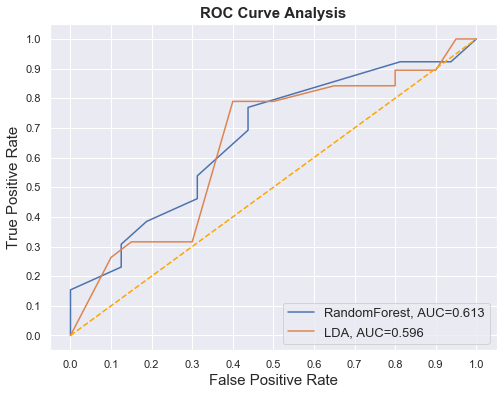

In [109]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

We can see that Random Forest performs a little better than LDA, we will use RF model to further tune the model and improve its predicitng power.

### Fine tune Random Forest Model

In [110]:
#Generate the random grid to fit in the Gridsearch

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [111]:
#train test split
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(os_data_X, os_data_y, test_size=0.4, random_state=0)

# Use the random grid to search for best hyperparameters
random.seed(123)

# Create the base model to tune
rf = RandomForestRegressor()

# For random search of parameters, using 5 fold cross validation, 
# search across 150 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30,\
                               cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model and select the best param
rf_random.fit(X_train_rf, y_train_rf)
rf_random.best_params_, rf_random.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   44.9s finished
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


({'n_estimators': 1800,
  'min_samples_split': 10,
  'min_samples_leaf': 4,
  'max_features': 'auto',
  'max_depth': 90,
  'bootstrap': True},
 -0.8399545686775282)

In [112]:
random.seed(123)

#RF model
rf = RandomForestClassifier(n_estimators=1600,min_samples_split=2,
                            min_samples_leaf=4,max_features='auto',max_depth= 90, bootstrap=True)
    
# Train the classifier
rf.fit(X_train_rf, y_train_rf)

y_pred_rf = rf.predict(X_test_rf)

/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [113]:
# accuracy: (tp + tn) / (p + n)
accuracy_tune = accuracy_score(y_test_rf, y_pred_rf)
print('Accuracy: %f' % accuracy_tune)

# precision tp / (tp + fp)
precision_tune = precision_score(y_test_rf, y_pred_rf)
print('Precision: %f' % precision_tune)

# recall: tp / (tp + fn)
recall_tune = recall_score(y_test_rf, y_pred_rf)
print('Recall: %f' % recall_tune)

# f1: 2 tp / (2 tp + fp + fn)
f1_tune = f1_score(y_test_rf, y_pred_rf)
print('F1 score: %f' % f1_tune)

# ROC AUC
auc_tune = roc_auc_score(y_test_rf, y_pred_rf)
print('ROC AUC: %f' % auc_tune)

Accuracy: 0.666667
Precision: 0.650000
Recall: 0.684211
F1 score: 0.666667
ROC AUC: 0.667105


In [114]:
fpr_tune, tpr_tune, thresholds_tune = roc_curve(y_test_rf, rf.predict_proba(X_test_rf)[:,1])

result_table = result_table.reset_index()

result_table = result_table.append({'classifier':'Tuned_RandomForest','accuracy':accuracy_tune,
                                    'precision':precision_tune,'recall':recall_tune,
                                    'f1':f1_tune,'auc':auc_tune,'fpr':fpr_tune, 'tpr':tpr_tune}, ignore_index=True)

result_table

,classifier,accuracy,precision,recall,f1,auc,fpr,tpr
0,RandomForest,0.620690,0.583333,0.538462,0.560000,0.612981,"[0.0, 0.0, 0.125, 0.125, 0.1875, 0.3125, 0.312...","[0.0, 0.15384615384615385, 0.23076923076923078..."
1,LDA,0.589744,0.551724,0.842105,0.666667,0.596053,"[0.0, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.65, 0.8...","[0.0, 0.2631578947368421, 0.3157894736842105, ..."
2,Tuned_RandomForest,0.666667,0.650000,0.684211,0.666667,0.667105,"[0.0, 0.0, 0.0, 0.05, 0.05, 0.2, 0.25, 0.25, 0...","[0.0, 0.05263157894736842, 0.2631578947368421,..."


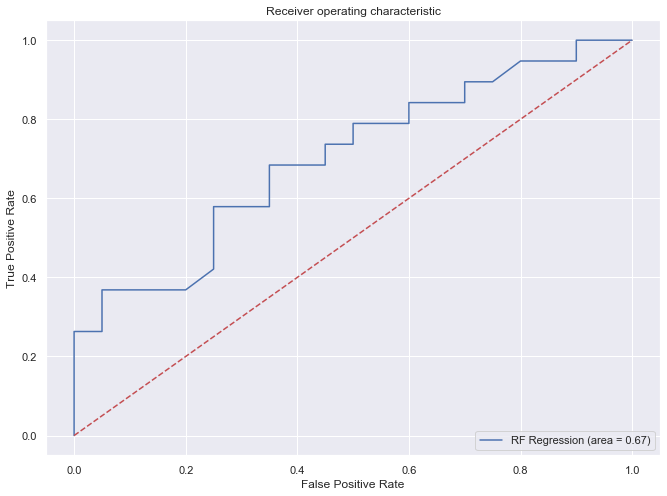

In [115]:
rf_roc_auc = roc_auc_score(y_test_rf, y_pred_rf)
fpr, tpr, thresholds = roc_curve(y_test_rf, rf.predict_proba(X_test_rf)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RF Regression (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

There is a significant improvement when I apply the tuned parameters, especially in Precision, with a 7.69% improvement!

## Conclusion

Through exploratory data analysis and machine learning analysis, I discovered my own music and movie tastes while understanding more about boyfriend’s favorite genres. 

According to this, I can conclude that his lists are more diverse than me in both songs and films. In addition, my songs imply more acousticness, danceability and valence (positivity), while his songs are more lively, energetic and instrumental. Another insight is that Sang enjoyed more short film when I repetitively iterate on TV-shows.

To dig deeper into the analysis, I found out the most predictive features that can accurately classify a song or a movie that is more likely to be chosen by me or Sang, and feed them in Machine Learning models accordingly. After trying different models to predict songs whether to be on my or Sang’s playlist, the best performing model is Logistic Regression. On the other hand, the best model to classify movie list is Random Forest with tuned parameters. 

In general, I’m super happy with what I discovered and hope my analysis can be benefited for predicting songs or movies for shared accounts on Netflix and Spotify to further improve user experience!
